In [6]:
# the notion of "biased coin" is ambiguous:
# 1. it could mean the coin has a specific p other than 0.5 (e.g. p=0.56)
# 2. it could mean the coin have any p other than 0.5, all these values are equally likely
#
# the two notions are different for that the first dictates that a coin has a specific bias,
# whereas the second notion assumes all possible biases has the same probability and then
# consider the posterior of seeing the result.

import numpy as np
import pandas as pd
from empiricaldist import Pmf
from scipy.stats import binom

# now let's analysize the likelihoods, P(result | presupposition) for each presupposition where result is {140H in 250 clips}.
#
k = 140
n = 250

like_fair = binom.pmf(k, n, p=0.5)
like_unfair = binom.pmf(k, n, p=0.56)
biased_dist = Pmf(1, np.linspace(0, 1, 101))
biased_dist[0.5] = 0
biased_dist.normalize()
biased_dist *= binom.pmf(k, n, p=biased_dist.qs)
like_biased = biased_dist.sum()
print(like_fair, like_unfair, like_biased)

0.008357181724918188 0.05077815959518337 0.0039004919277707355


0.006981325464857881


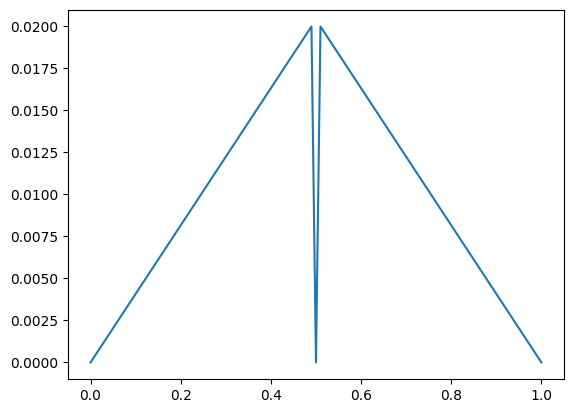

In [9]:
# another presupposition is that the dice may be biased but more likely biased at the middle (close to p=0.5).
# i.e. it's less likely to be p=0.1 than p=0.6. for this we can use a triangular shape distribution as our prior biased distribution.
trig_biased_dist = Pmf(list(range(50)) + list(range(50, -1, -1)), biased_dist.qs)
trig_biased_dist[0.5] = 0
trig_biased_dist.normalize()
trig_biased_dist.plot()
trig_biased_dist *= binom.pmf(k, n, p=trig_biased_dist.qs)
like_biased_trig = trig_biased_dist.sum()
print(like_biased_trig)

,likelihoood,compare to fair
Fair,0.008357,1.000000
p=0.56,0.050778,6.075991
Evenly biased,0.003900,0.466723
Trigly biased,0.006981,0.835368


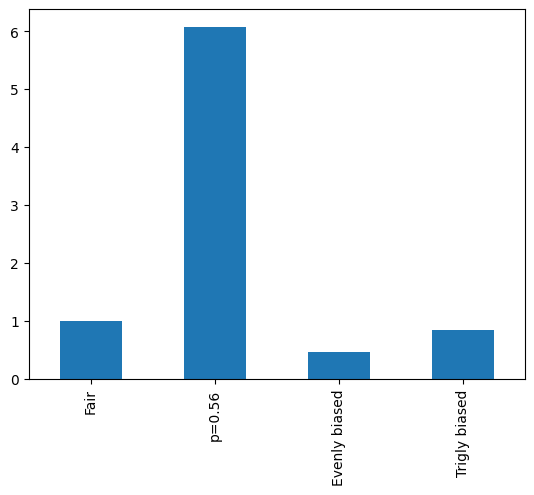

In [15]:
df = pd.DataFrame()
df.index = ['Fair', 'p=0.56', 'Evenly biased', 'Trigly biased']
df['likelihoood'] = [like_fair, like_unfair, like_biased, like_biased_trig]
df['compare to fair'] = df['likelihoood'] / df['likelihoood']['Fair']
df['compare to fair'].plot(kind='bar')
df

Above analysis shows the procedure of what's called "Bayesian hypothesis testing", in contrast to the widely used "Statistical hypothesis testing".
In short, instead of giving out a p-value for how statistically significant is the hypothesis,
we give out the likelihood (Bayesian factor) for one theory against others. This method avoids dispute on the arbitrary prior
(which hypos are more likely). However, calculating each Bayesian factor, we still need a precise and sometimes arbitrary definition
of the hypothesis, which on its own is still disputable.

The author's opinion is that despite the room for controversy, the Bayesian method is still superior because it talks about
the "strength of an evidence" instead of "probability of a theory is true", yielding a continuum instead of a binary assertion. The usefulness comes from the ability to make prediction and make decision:

- Prediction: Based on what we know about the coin, what should we expect to happen in the future?
- Decision making: Can we make use the prediction to make better decisions?

Rather than knowing the "truthfulness" of a particularly hypothesis. From this perspective, the Bayesian method is already useful.